In [2]:
import pandas as pd 
import numpy as np

import sys

In [3]:
blood_data = pd.read_csv("./data/Blood_data_Tema.csv")

In [4]:
blood_data.isna().sum()

YEAR             0
MONTH            0
QTY_DEMANDED    13
QTY_SUPPLIED     9
dtype: int64

In [5]:
blood_data_without_na = blood_data.fillna({"QTY_DEMANDED": 0, "QTY_SUPPLIED": 0})  # Replace NaNs with 0

In [6]:
blood_data_without_na.isna().sum()

YEAR            0
MONTH           0
QTY_DEMANDED    0
QTY_SUPPLIED    0
dtype: int64

In [7]:
blood_data_without_na.head()

,YEAR,MONTH,QTY_DEMANDED,QTY_SUPPLIED
0,2013,January,162.0,136.0
1,2013,February,188.0,202.0
2,2013,March,229.0,225.0
3,2013,April,220.0,204.0
4,2013,May,252.0,251.0


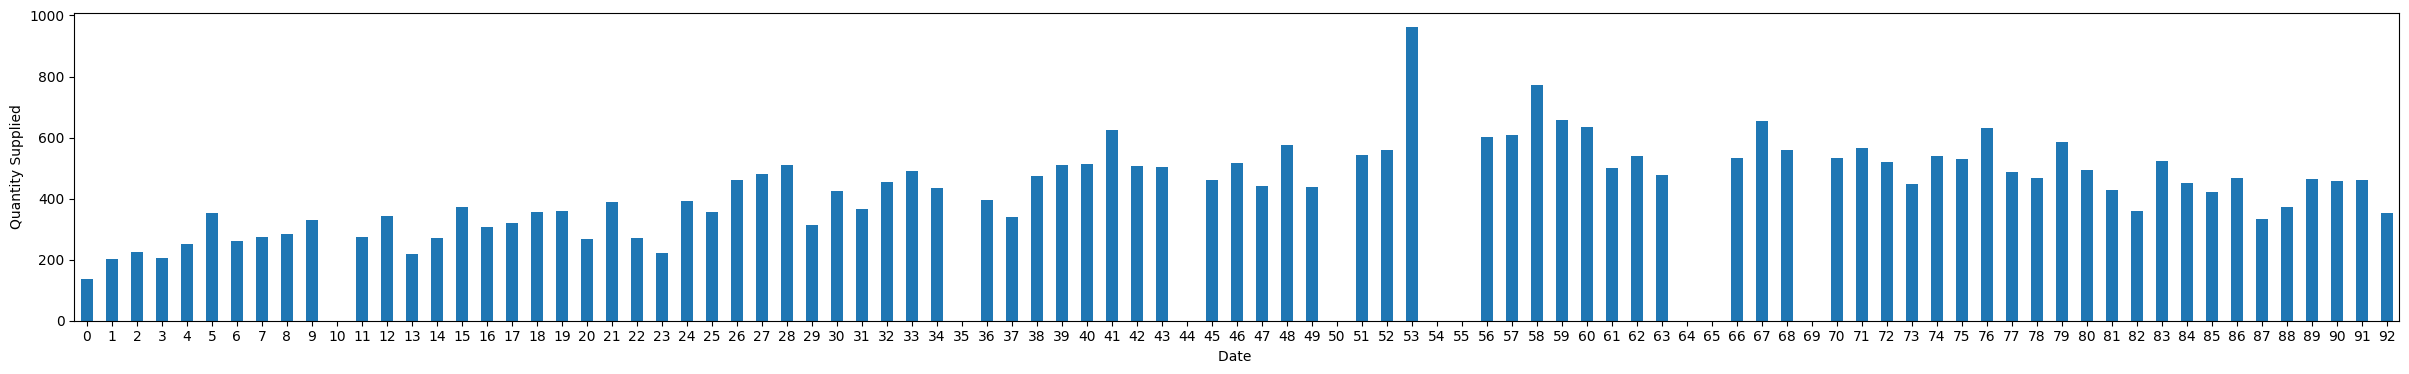

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(30, 4))

blood_data_without_na['QTY_SUPPLIED'].plot(kind='bar', rot=0, ax=axs)

plt.xlabel("Date ");  # custom x label using Matplotlib

plt.ylabel("Quantity Supplied");

In [9]:
years = blood_data_without_na["YEAR"].unique().tolist()
months = blood_data_without_na["MONTH"].unique().tolist()

In [10]:
years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [11]:
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [12]:
blood_data_yearly = blood_data_without_na.groupby("YEAR")[["QTY_DEMANDED", "QTY_SUPPLIED"]].sum().reset_index()

In [13]:
blood_data_yearly

,YEAR,QTY_DEMANDED,QTY_SUPPLIED
0,2013,2918.0,2791.0
1,2014,3067.0,3699.0
2,2015,3071.0,4684.0
3,2016,2457.0,5286.0
4,2017,3872.0,5717.0
5,2018,4257.0,4999.0
6,2019,3696.0,6017.0
7,2020,2815.0,3778.0


array([[<Axes: title={'center': 'QTY_DEMANDED'}>,
        <Axes: title={'center': 'QTY_SUPPLIED'}>]], dtype=object)

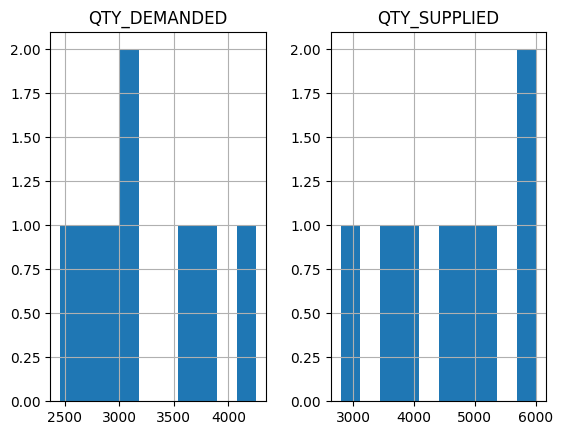

In [14]:
blood_data_yearly[["QTY_DEMANDED", "QTY_SUPPLIED"]].hist()

## Scaling the data

In [15]:
from sklearn.preprocessing import MinMaxScaler


year_scaler = MinMaxScaler()
month_scaler = MinMaxScaler()

scaled_blood_data_yearly = blood_data_yearly.copy()
scaled_blood_data_monthly = blood_data_without_na.copy()

scaled_blood_data_yearly[["QTY_DEMANDED","QTY_SUPPLIED"]] = year_scaler.fit_transform(blood_data_yearly[["QTY_DEMANDED","QTY_SUPPLIED"]])
scaled_blood_data_monthly[["QTY_DEMANDED","QTY_SUPPLIED"]] = month_scaler.fit_transform(blood_data_without_na[["QTY_DEMANDED","QTY_SUPPLIED"]])

In [16]:
scaled_blood_data_yearly

,YEAR,QTY_DEMANDED,QTY_SUPPLIED
0,2013,0.256111,0.000000
1,2014,0.338889,0.281463
2,2015,0.341111,0.586795
3,2016,0.000000,0.773404
4,2017,0.786111,0.907006
5,2018,1.000000,0.684439
6,2019,0.688333,1.000000
7,2020,0.198889,0.305952


## Creating the model

In [17]:
import tensorflow as tf 
import keras

from keras.layers import LSTM, Input, Dropout, Embedding, Dense, add
from keras import Model
from keras.utils import plot_model

2024-12-05 18:36:47.145040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 18:36:47.145118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 18:36:47.175047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 18:36:47.227379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 18:36:48.507523: W tensorflow/compiler/tf2

In [18]:
# model parameters

N_INPUT_YEARS = 4
N_INPUT_MONTHS = 6

DROP_OUT_RATE = 0.2

BATCH_SIZE = 16
N_EPOCHS = 10


In [19]:

def get_model():
    year_input_layer = Input(shape=((N_INPUT_YEARS,1 )))
    year_lstm_layer = LSTM(128, name="year_lstm")(year_input_layer)
    year_fc_1 = Dense(256)(year_lstm_layer)
    year_dropout = Dropout(DROP_OUT_RATE)(year_fc_1)
    year_fc_2 = Dense(500)(year_dropout)
    
    month_input_layer = Input(shape=((N_INPUT_MONTHS, 1)))
    month_lstm_layer = LSTM(128, name="month_lstm")(month_input_layer)
    month_fc_1 = Dense(256)(month_lstm_layer)
    month_dropout = Dropout(DROP_OUT_RATE)(month_fc_1)
    month_fc_2 = Dense(500)(month_dropout)
    
    combine = add([year_fc_2, month_fc_2])
    dense_decoder = Dense(256, activation='relu')(combine)

    output = Dense(1, activation="sigmoid")(dense_decoder)

    return Model(inputs=[year_input_layer, month_input_layer], outputs=output)


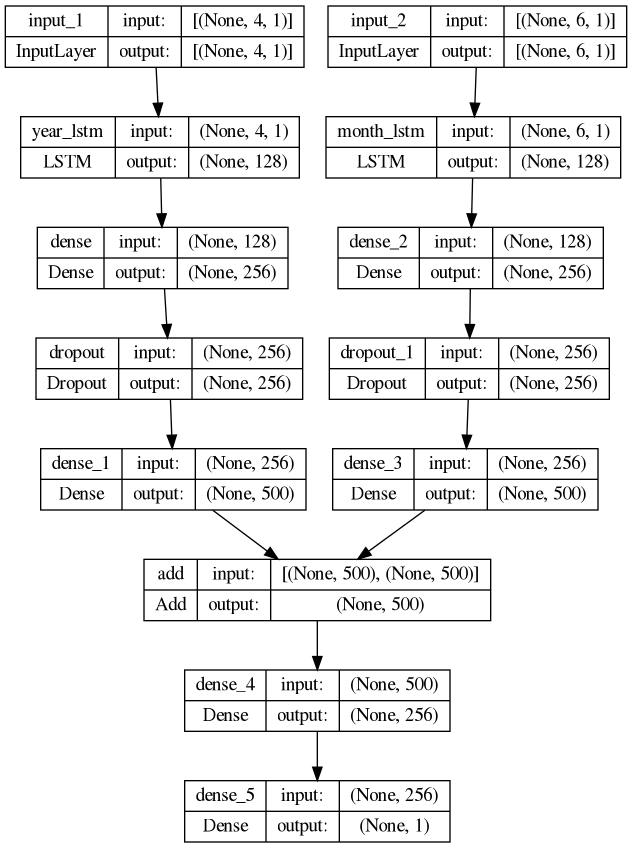

In [20]:
model = get_model()

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


In [21]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [22]:
def data_generator(batch_size=16, batch_size_year: int = 4, batch_size_month: int = 6):
    len_scaled_blood_data_yearly = len(scaled_blood_data_yearly)
    start_year = scaled_blood_data_yearly.loc[0, "YEAR"]
    while True:
        yr_inputs, mth_inputs, outputs = [], [], []
        sample = 0
        
        for i in range(1, len_scaled_blood_data_yearly - batch_size_year - 1):
            current_year = scaled_blood_data_yearly.loc[i, "YEAR"]
            next_year_data = scaled_blood_data_monthly[scaled_blood_data_monthly["YEAR"] == current_year + 1]
    
            year_input_data = scaled_blood_data_yearly.loc[i: i+batch_size_year - 1, "QTY_SUPPLIED"]
    
            for j in range(12):
                month_input_data = scaled_blood_data_monthly.loc[(current_year - start_year) * 12 + j + 1 - batch_size_month : (current_year - start_year) * 12 + j, "QTY_DEMANDED"]
                to_predict = scaled_blood_data_monthly.loc[(current_year - start_year) * 12 + j + 1, "QTY_SUPPLIED"]
                
                yr_inputs.append(year_input_data.values)
                mth_inputs.append(month_input_data.values)
                outputs.append(to_predict)
                sample += 1
    
    
                if sample >= batch_size:
                    sample = 0
                    yield ([np.array(yr_inputs), np.array(mth_inputs)], np.array(outputs))
                    
                    yr_inputs, mth_inputs, outputs = [], [], []
    
                    

In [23]:
default_data_generator = data_generator(batch_size=16)

steps_per_epoch = 50

history = model.fit(
        default_data_generator, 
        epochs=N_EPOCHS, 
        steps_per_epoch=steps_per_epoch, 
        verbose=1,
)

Epoch 1/10
50/50 [==============================] - 4s 14ms/step - loss: 0.0080 - mae: 0.0727
Epoch 2/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0038 - mae: 0.0522
Epoch 3/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0031 - mae: 0.0459
Epoch 4/10
50/50 [==============================] - 1s 12ms/step - loss: 0.0018 - mae: 0.0334
Epoch 5/10
50/50 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0272
Epoch 6/10
50/50 [==============================] - 1s 12ms/step - loss: 8.1635e-04 - mae: 0.0212
Epoch 7/10
50/50 [==============================] - 1s 12ms/step - loss: 5.8610e-04 - mae: 0.0176
Epoch 8/10
50/50 [==============================] - 1s 12ms/step - loss: 4.9095e-04 - mae: 0.0162
Epoch 9/10
50/50 [==============================] - 1s 12ms/step - loss: 2.8068e-04 - mae: 0.0130
Epoch 10/10
50/50 [==============================] - 1s 12ms/step - loss: 1.6947e-04 - mae: 0.0101


In [29]:
year_inputs = year_scaler.transform([[1000,1000],[3000,3000], [2000,2000], [1500,1500]])
months_inputs = month_scaler.transform([[100,100],[200,200], [150,150], [250,250], [300,300], [100,100]])


predictions = model.predict([np.array(year_inputs[:, 1]).reshape(1, N_INPUT_YEARS), np.array(months_inputs[:, 1]).reshape(1, N_INPUT_MONTHS)])

predictions


1/1 [==============================] - 0s 21ms/step


/home/bishal/Programming/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/bishal/Programming/.venv/lib64/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.20825031]], dtype=float32)

In [30]:
month_scaler.get_feature_names_out()

array(['QTY_DEMANDED', 'QTY_SUPPLIED'], dtype=object)

In [31]:
# Add a dummy feature (zeros)
dummy_feature = np.zeros((predictions.shape[0], 1))
predictions_with_dummy = np.hstack([predictions, dummy_feature])

# Transform using the scaler
transformed = month_scaler.inverse_transform(predictions_with_dummy)

# Extract only the transformed feature
transformed_predictions = transformed[:, 0]

print(transformed_predictions)

[254.27363339]


In [38]:
year_scaler.get_feature_names_out()

array(['QTY_DEMANDED', 'QTY_SUPPLIED'], dtype=object)

In [34]:
year_scaler.data_min_

array([2457., 2791.])

In [35]:
year_scaler.data_max_

array([4257., 6017.])

In [39]:
month_scaler.get_feature_names_out()

array(['QTY_DEMANDED', 'QTY_SUPPLIED'], dtype=object)

In [36]:
month_scaler.data_min_

array([0., 0.])

In [37]:
month_scaler.data_max_

array([1221.,  961.])